# The map equation
http://www.mapequation.org/assets/publications/EurPhysJ2010Rosvall.pdf


In [1]:
%matplotlib inline

In [2]:
import math
import random
import time

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import d3shims

In [3]:
G = nx.Graph()
G.add_edges_from([
    (1, 2), (1, 3), (2, 3), (4, 2), (5, 2), (5, 6), (2, 6), 
    (3, 6), (3, 7), (7, 8), (7, 9), (7, 10), (9, 10), (9, 11), 
    (8, 9), (8, 12), (9, 12), (11, 12), (13, 12), (13, 11), 
    (13, 10), (13, 14), (14, 15), (14, 16), (15, 16), (15, 17), 
    (16, 17), (16, 18), (18, 19), (19, 20), (20, 18), (18, 21), 
    (21, 22), (22, 20), (19, 22), (23, 22), (24, 22), (25, 22), 
    (25, 24), (25, 21), (25, 10),
])

optimal_modules = [
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10, 11, 12, 13],
    [14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23, 24, 25],
]

In [4]:
size = (300, 300)
d3shims.nx_force(G, size=size)

For a module partition $M$ of $n$ nodes $α = 1, 2,...,n$ into $m$ modules $i = 1, 2,...,m$, we define this lower bound on code length to be $L(M)$. To calculate $L$ for an arbitrary partition, we first invoke [Shannon's source coding theorem](https://en.wikipedia.org/wiki/Shannon%27s_source_coding_theorem), which implies that when you use $n$ codewords to describe the $n$ states of a random variable $X$ that occur with frequencies $p_i$, the average length of a codeword can be no less than the entropy of the random variable $X$ itself: $H(X) = - \sum p_i log_2(p_i)$ (we measure code lengths in bits and take the logarithm in base 2).

In [5]:
freqs = [100, 10]
n = len(freqs)
pi = [f / sum(freqs) for f in freqs]

In [6]:
H = -sum(p * math.log2(p) for p in pi)
print('Theoretical minimum to encode each state: {:0.3f} bits'.format(H))

Theoretical minimum to encode each state: 0.439 bits


---

### Sidebar: Random Walker probability of visiting any given node in an undirected graph

Equal to the number of neighbors the node has, divided by twice (one per link end) the total edge weight of the graph: "relative weight", $w_\alpha$.

In [7]:
nodes = G.nodes()
edges = G.edges()

neighbors = [len(G.neighbors(n)) for n in nodes]
counts = {k: 0 for k in nodes}
loc = random.choice(list(counts.keys()))

iters = int(5e5)
for step in range(iters):
    loc = random.choice(G.neighbors(loc))
    counts[loc] += 1

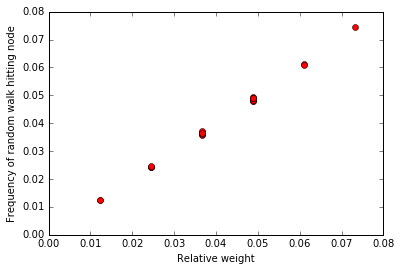

In [8]:
f, ax = plt.subplots()
ax.plot([n/len(edges)/2 for n in neighbors], [counts[n]/iters for n in nodes], 'ro')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel('Relative weight')
ax.set_ylabel('Frequency of random walk hitting node')
plt.show()

---

## The equation
  
$$L(\mathsf{M}) = q_\curvearrowright H(\mathcal{Q}) + \sum_{i = 1}^{m}p^i_\circlearrowright H(\mathcal{P}^i)$$

* $H(\mathcal{Q})$ - frequency weighted average length of codewords in the index codebook
* $H(\mathcal{P}^i)$ - frequency weighted average length of codewords in the module cookbook $i$
* $q_{i\curvearrowright}$ - probability to exit module $i$
  * $q_{\curvearrowright} = \sum_i q_{i\curvearrowright}$  - probability to exit any module and use the module cookbook
* $p_\alpha$ - probability to visit node $\alpha$
  * $p^i_\circlearrowright = \sum_{\alpha \in i} p_\alpha + q_{i \curvearrowright}$ - probability to use the module cookbook $i$: how often the random walk is in the module plus the frequency that the module is exited

For convienence, let $f(x) = x \log x$

$$H(\mathcal{Q}) = - \sum^m_{i=1}{f\left(\frac{q_{i \curvearrowright}}{\sum^m_{j=1}{q_{j \curvearrowright}}}\right)}$$

$$H(\mathcal{P}^i) = 
 - f\left(\frac{q_{i \curvearrowright}}{q_{i \curvearrowright} + \sum_{\beta \in i}{p_\beta}}\right) 
 - \sum_{\alpha \in i}{f\left(\frac{p_\alpha}{q_{i \curvearrowright} + \sum_{\beta \in i}{p_\beta}}\right)}$$

After combining and simplifying

$$L(\mathsf{M}) = 
 f\left(\sum^{m}_{i=1}{q_{i \curvearrowright}}\right)
 - 2 \sum^{m}_{i=1}{f\left(q_{i \curvearrowright}\right)}
 - \sum^{n}_{\alpha=1}{f\left(p_\alpha\right)}
 + \sum^{m}_{i=1}{f\left(q_{i \curvearrowright} + \sum_{\alpha \in i}{p_\alpha}\right)}$$


In an undirected network:

* $w_\alpha$ : the relative weight of node $\alpha$
* $w_i = \sum_{\alpha \in i}w_\alpha$ : the relative weight of module $i$
* $w_{i \curvearrowright}$ : the relative weight of links exiting module $i$
* $w_\curvearrowright = \sum^m_{i=1}w_{i \curvearrowright}$ : the relative weight of links between all modules

$$
L(\mathsf{M}) = 
 f\left(w_{ \curvearrowright}\right)
 - 2 \sum^{m}_{i=1}{f\left(w_{i \curvearrowright}\right)}
 - \sum^{n}_{\alpha=1}{f\left(w_\alpha\right)}
 + \sum^{m}_{i=1}{f\left(w_{i \curvearrowright} + w_i\right)}
$$

In [9]:
def total_edge_weight(G):
    return (1 if G.is_directed() else 2) * sum(edge[2].get('weight', 1) for edge in G.edges_iter(data=True))

# def node_weight(G, n):
#     return sum(edge[2].get('weight', 1) for edge in G.edges_iter(n, data=True))
    
def node_weight(G, n):
    accum = 0
    for edge in G.edges_iter(n, data=True):
        weight = edge[2].get('weight', 1)
        accum += weight
    return accum

def relative_weight(G, n):
    if 'rw' not in G.node[n]:
        G.node[n]['rw'] = node_weight(G, n) / total_edge_weight(G)
    return G.node[n]['rw']

In [10]:
relative_weight(G, 4)

0.012195121951219513

In [11]:
G.node[4]

{'rw': 0.012195121951219513}

* graph total weight
* node relative weight
* module relative weight
* node to module map
* module to node map


In [12]:
from collections import defaultdict 
import copy

def nlogn(n):
    return n * np.log2(n)

class MapEqnManager:
    def __init__(self, graph):
        self.G = graph
        if self.G.is_directed():
            raise ValueError('directed graphs not supported yet')
        
        self._init_weights()
        self._init_modules()

    def _init_weights(self):
        self.Gtw = total_edge_weight(self.G)
        self.nrw = {}
        for n in self.G.nodes_iter():
            self.nrw[n] = node_weight(self.G, n) / self.Gtw
        self.term3 = -sum(nlogn(rw) for rw in self.nrw.values())

    def _init_modules(self):
        self.nm = {}
        self.mn = defaultdict(set)
        
        # each node is it's own module at the start
        for n in self.G.nodes_iter():    
            self.nm[n] = n
            self.mn[n].add(n)
        
    def module_weight(self, m):
        return sum(self.nrw[n] for n in self.mn[m])
    
    def module_exit_weight(self, m):
        return sum(self.G.node[n].get('weight', 1) / self.Gtw 
                for n, neighbor 
                in self.G.edges_iter(self.mn[m]) 
                if neighbor not in self.mn[m])
    
    def total_exit_weight(self):
        return sum(self.module_exit_weight(m) for m, nodes in self.mn.items() if nodes)
        
    def move_node_to_module(self, n, m):
        self.mn[self.nm[n]].remove(n)
        
        self.nm[n] = m
        self.mn[m].add(n)
    
    def move_nodes_to_module(self, nodes, m):
        for n in set(nodes):
            self.move_node_to_module(n, m)
    
    def code_length(self):
        mod_weights = {m: self.module_weight(m) for m, nodes in self.mn.items() if nodes}
        if len(mod_weights) == 1:
            # single module, the other terms are useless/invalid
            return self.term3
        
        mod_exit_weights = {m: self.module_exit_weight(m) for m in mod_weights}
        total_exit_weight = sum(mod_exit_weights.values())
        return (nlogn(total_exit_weight) 
                - 2 * sum(nlogn(ew) for ew in mod_exit_weights.values()) 
                + self.term3 
                + sum(nlogn(mod_weights[m] + mod_exit_weights[m]) for m in mod_weights))
    
    def module_neighbors(self, m):
        module_neighbors = set()
        
        for node in self.mn[m]:
            for neighbor in self.G.neighbors(node):
                module_neighbors.add(self.nm[neighbor])
        module_neighbors.discard(m)
        
        return module_neighbors

    ######## TESTING / VISUALIZATION #######

    def _d3(self, *args, **kwargs):
        # copy modules to "group" attribute on nodes
        for n, m in self.nm.items():
            self.G.node[n]['group'] = m
        return d3shims.nx_force(self.G, *args, **kwargs)
    
    def _single_module(self, the_one=1):
        for n in self.nm:
            self.nm[n] = the_one
        self.mn = defaultdict(set, {the_one: set(self.nm)})
    
    def _verify_module_map_consistency(self):
        """
        Checks synchronization between node->module and module->nodes mappings
        """
        nodes = set(self.nm)
        mn_temp = copy.deepcopy(self.mn)
        while nodes:
            n = nodes.pop()
            m = self.nm[n]
            try:
                mn_temp[m].remove(n)
            except KeyError:
                raise AssertionError('node {} not in expected module {}'.format(n, m))
        
        for m, m_leftovers in mn_temp.items():
            assert not m_leftovers, 'extra node in module map! (node(s) {} in module {})'.format(m_leftovers, m)
        

In [13]:
mem = MapEqnManager(G)
mem._verify_module_map_consistency()
mem.code_length()

6.5433062000996918

In [14]:
mem._single_module()
mem._verify_module_map_consistency()
mem.code_length()

4.54330620009969

In [15]:
for module, nodes in enumerate(optimal_modules):
    for node in nodes:
        mem.move_node_to_module(node, module)
mem.code_length()

3.2670285810463575

In [16]:
mem._d3((300, 300))

## Minimizing the Map Equation

### "Core algorithm"
1. Randomly order the nodes
1. For each node, move to the neighboring module that provides the greatest decrease. If nothing provides a decrease, keep as-is.
1. Repeat the above steps until no changes result in a decrease of the map equation.
1. Transform the modules found above into nodes and repeat the process.

In [17]:
mem = MapEqnManager(G)
mem.code_length()

6.5433062000996918

In [18]:
def get_nodes_and_shuffle(G):
    nodes = list(G.nodes_iter())
    random.shuffle(nodes)
    return nodes

nodes = get_nodes_and_shuffle(mem.G)
print(nodes)

[16, 25, 6, 23, 5, 3, 19, 22, 18, 15, 2, 1, 21, 10, 7, 17, 12, 13, 4, 11, 20, 24, 8, 9, 14]


In [19]:
def find_greatest_neighbor_decrease(mG, n):
    node_module = mG.nm[n] # module of focal node
    neighbors = mG.G.neighbors(n)
    scores = {None: mG.code_length()}
    
    for neighbor in neighbors:
        original_module = mG.nm[neighbor]
        mG.move_node_to_module(neighbor, node_module)
        scores[neighbor] = mG.code_length()
        mG.move_node_to_module(neighbor, original_module)
        
    return min(scores.keys(), key=lambda k: scores[k])

print(mem.G.neighbors(1))
print(find_greatest_neighbor_decrease(mem, 1))

[2, 3]
3


In [20]:
mem._d3(size=size)

In [21]:
def node_collapse_iteration(mG):
    nodes = get_nodes_and_shuffle(mG.G)
    
    start = mG.nm.copy()
    #changed = False
    for n in nodes:
        best = find_greatest_neighbor_decrease(mG, n)
        if best is None:
            continue
        mG.move_node_to_module(best, mG.nm[n])
        # oscillations might be thwarting "any change" meaning "a net change"
        # need to check, for now just check en-masse at start/end
        #changed = True 

    return set(start.items()) != set(mG.nm.items())

In [22]:
node_collapse_iteration(mem)
mem._d3((300, 300))

In [23]:
mem = MapEqnManager(G)
start = time.time()
while True:
    changes = node_collapse_iteration(mem)

    if not changes:
        break
    elif time.time() - start > 5:
        raise Exception('timeout')

print(mem.code_length())
mem._d3(size=size)

3.52818480528


In [24]:
def get_modules_and_shuffle(mG):
    modules = [module for module, nodes in mG.mn.items() if nodes]
    random.shuffle(modules)
    return modules

modules = get_modules_and_shuffle(mem)
print(modules)

[15, 9, 24, 6, 13, 20]


In [25]:
def find_greatest_module_neighbor_decrease(mG, module):
    module_neighbors = mG.module_neighbors(module)
            
    scores = {None: mG.code_length()}
    
    for mneighbor in module_neighbors:
        nodes = set(mG.mn[mneighbor]) # copy
        mG.move_nodes_to_module(nodes, module)
        scores[mneighbor] = mG.code_length()
        mG.move_nodes_to_module(nodes, mneighbor)
        
    return min(scores.keys(), key=lambda k: scores[k])

find_greatest_module_neighbor_decrease(mem, 19)

In [26]:
def module_collapse_iteration(mG):
    modules = get_modules_and_shuffle(mG)
    
    start = set(mG.nm.items())
    for m in modules:
        mbest = find_greatest_module_neighbor_decrease(mG, m)
        if mbest is None:
            continue
        mG.move_nodes_to_module(mG.mn[mbest], m)

    return start != set(mG.nm.items())

In [27]:
start = time.time()
while True:
    changes = module_collapse_iteration(mem)

    if not changes:
        break
    elif time.time() - start > 5:
        raise Exception('timeout')

print(mem.code_length())
mem._d3(size=size)

3.26702858105


In [28]:
def core_algorithm(G, timeout=5):
    mG = MapEqnManager(G)

    start = time.time()
    e = Exception('timeout')

    while time.time() - start < timeout:
        changes = node_collapse_iteration(mG)
        if not changes:
            break
    else:
        raise e
            
    while time.time() - start < timeout:
        changes = module_collapse_iteration(mG)
        if not changes:
            break
    else:
        raise e

    return mG
            
mG = core_algorithm(G)
print(mG.code_length())
mG._d3(size)

3.26702858105


In [29]:
import itertools

messier = nx.Graph()

total_nodes = 100
groups = 6
min_group_size = 8

group_bounds = [0, total_nodes]

while True:
    b = random.randrange(total_nodes)
    if min(abs(x - b) for x in group_bounds) < min_group_size:
        continue
    group_bounds.append(b)
    if len(group_bounds) >= groups:
        break
        
group_bounds.sort()

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

p_intra = 0.1
p_inter = 0.02

for group_range in pairwise(group_bounds):
    nodes = list(range(*group_range))
    possible_intragroup_edges = itertools.combinations(nodes, 2)
    for edge in possible_intragroup_edges:
        if random.random() < p_intra * math.log(len(nodes)):
            messier.add_edge(*edge)
    for node, degree in messier.degree_iter(nodes):
        if degree == 0:
            messier.add_edge(node, random.choice(nodes)) # guarantee connectivity

possible_intergroup_edges = itertools.combinations(range(total_nodes), 2)
messier.add_edges_from(e for e in possible_intergroup_edges if random.random() < p_inter)

print(group_bounds)
d3shims.nx_force(messier)

[0, 19, 40, 53, 68, 100]


In [30]:
%%time
mess = core_algorithm(messier, 10)
print(mess.code_length())

5.73083074832
CPU times: user 4.62 s, sys: 30.1 ms, total: 4.65 s
Wall time: 4.7 s


In [31]:
mess._single_module()
one_level_codelength = mess.code_length()
one_level_codelength

6.4959798892045972

In [32]:
scores = []
best = None
for i in range(100):
    print('{: 3}...'.format(i+1), end=" ")
    mess = core_algorithm(messier, 15)
    scores.append(mess.code_length())
    if scores[-1] <= min(scores):
        best = mess
best._d3(linkdistance=50)

  1...   2...   3...   4...   5...   6...   7...   8...   9...  10...  11...  12...  13...  14...  15...  16...  17...  18...  19...  20...  21...  22...  23...  24...  25...  26...  27...  28...  29...  30...  31...  32...  33...  34...  35...  36...  37...  38...  39...  40...  41...  42...  43...  44...  45...  46...  47...  48...  49...  50...  51...  52...  53...  54...  55...  56...  57...  58...  59...  60...  61...  62...  63...  64...  65...  66...  67...  68...  69...  70...  71...  72...  73...  74...  75...  76...  77...  78...  79...  80...  81...  82...  83...  84...  85...  86...  87...  88...  89...  90...  91...  92...  93...  94...  95...  96...  97...  98...  99...  100... 

(array([ 57.,  11.,  14.,   6.,   9.,   0.,   0.,   1.,   0.,   2.]),
 array([ 5.71587162,  5.72320904,  5.73054646,  5.73788388,  5.7452213 ,
         5.75255872,  5.75989614,  5.76723356,  5.77457098,  5.7819084 ,
         5.78924582]),
 <a list of 10 Patch objects>)

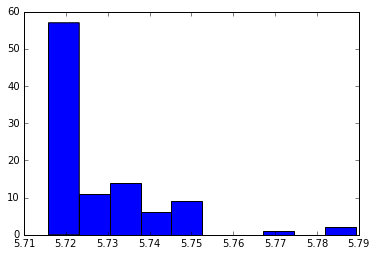

In [33]:
plt.hist(scores)

In [34]:
import json
import io
import hashlib

buf = io.BytesIO()
nx.write_pajek(messier, buf)
hash_id = hashlib.md5(buf.getvalue()).hexdigest()[:10]

json_fn = 'log-{}.json'.format(hash_id)
pajek_fn = 'network-{}.net'.format(hash_id)

data = {
    'graph_edges': list(messier.edges()),
    'best_score': best.code_length(),
    'best_groups': [list(n) for m, n in best.mn.items() if n],
}
with open(json_fn, 'w') as f:
    json.dump(data, f)

nx.write_pajek(messier, pajek_fn)

In [35]:
%%bash
../infomap/Infomap -h

Name:
        Infomap - Implementation of the Infomap clustering algorithm based on the Map Equation (see www.mapequation.org)

Usage:
        Infomap network_file out_directory [options]

[network_file]
    The file containing the network data. Accepted formats: Pajek (implied by .net) and link list (.txt)

[out_directory]
    The directory to write the results to

[options]
  -h[+] --help [+]                                  Prints this help message. Use -hh to show advanced options.
  -V    --version                                   Display program version information.
  -i<s> --input-format <s>                          Specify input format ('pajek', 'link-list', 'states', '3gram', 'multiplex' or 'bipartite') to override format possibly implied by file extension.
        --overlapping                               Let nodes be part of different and overlapping modules. Applies to ordinary networks by first representing the memoryless dynamics with memory nodes.
  -z    --zero-based

In [36]:
%%bash -s "$pajek_fn"
mkdir -p out
../infomap/Infomap $1 out/ -2

  Infomap v0.18.2 starts at [2016-02-17 21:14:53]
  -> Input network: network-ce67bb054a.net
  -> Output path:   out/
  -> Configuration: two-level
  -> Use undirected flow and 1st order Markov dynamics
Parsing undirected network from file 'network-ce67bb054a.net'... done!
 ==> 100 nodes (with total weight 0) and 431 links.
Calculating global flow... 
  -> Using undirected links.
Calculating one-level codelength... done!
  -> One-level codelength: 6.495979889

Attempt 1/1 at [2016-02-17 21:14:53]
Initiated to codelength 6.49598 + 2 = 8.495979889 in 100 modules.
Two-level compression: 6% 6.4% to 5 modules with codelength 5.715871618

Building output tree... writing .tree... done!


Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         100] (sum: 100)
Per level average child degree:      [          5,          20] (average: 19.2857)
Per level codelength for modules:    [0.

In [37]:
print('Python optimized Map code size: {:2.9f} bits'.format(data['best_score']))
print('Python single level code size:  {:2.9f} bits'.format(one_level_codelength))

Python optimized Map code size: 5.715871618 bits
Python single level code size:  6.495979889 bits


In [46]:
modules = defaultdict(set)
import glob
import os

newest = max(glob.iglob('out/*.tree'), key=os.path.getctime)
with open(newest) as f:
    for line in f:
        if line.startswith('#'):
            continue
        cols = line.split()
        modules[int(cols[0].split(':')[0])].add(int(cols[3]))
modules = dict(modules)

def sum_min(x):
    return (sum(x), min(x))

info_groups = sorted([sorted(list(v)) for v in modules.values()], key=sum_min)
group_tweak = sorted([sorted([x+1 for x in group]) for group in data['best_groups']], key=sum_min)
for i, g in zip(info_groups, group_tweak):
    assert set(i) == set(g)
else:
    print('We found the same modules as the Infomap C program!')

We found the same modules as the Infomap C program!
